In [1]:
%matplotlib inline

from modsim import *

In [2]:
tc= 3        #time between contacts in days
tr =4        #recovery time in days
th=2         #time sick but appear healthy in days

beta=1/tc    #contact rate in per day
gamma =1/tr  #recovery rate in per day
omega= 1/th  #sick appearance rate in per day

alpha = .6   #percent of sick people who take medicine

In [3]:
def make_system(beta, gamma, omega, alpha):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=349, I_H=1, I_M=0, I_NM=0, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, omega=omega, alpha=alpha)

In [4]:
def plot_results(S, I_H, I_M, I_NM, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    I_H: TimeSeries
    I_U: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I_H, '-', color='red', label='Infected but Appear Healthy')
    plot(I_M, '-', color='purple', label='Infected and are Taking Medicine')
    plot(I_NM, '-', color='orange', label='Infected and are not Taking Medicine')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [5]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [10]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for i in linrange(system.t0, system.t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame

In [17]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """

    s, i_h, i_m, i_nm, r = state

    # Infected-Healthy
    #still_IH = i_h * omega
    new_IH = s * ((i_h + i_m + i_nm)) * system.beta
    #infected_Healthy = still_IH + new_IH
    
    # Infected-Medicine
    #still_IM = (1-gamma)*i_m
    new_IM = system.alpha * i_h * (1 - system.omega)
    #infected_Med = still_IM + new_IM
    
    # Infected-NoMedicine
    #stillNM = (1-gamma)*i_nm
    newNM = (1 - system.alpha)*i_h*(1 - system.omega)
    #infected_No_Med = stillNM + newNM
    
    recovered = system.gamma * (i_m + i_nm)
    
    s -= new_IH
    i_h +=  new_IH - newNM - new_IM
    i_m += new_IM - (recovered * system.alpha)
    i_nm += newNM - (recovered*(1 - system.alpha))
    r += recovered
    
    return State(S=s, I_H=i_h, I_M=i_m, I_NM=i_nm, R=r)

In [18]:
system = make_system(beta, gamma, omega, alpha)
run_simulation(system, update1)
system.results

S       I_H       I_M      I_NM         R
0   0.997143  0.002857  0.000000  0.000000  0.000000
1   0.996193  0.002378  0.000857  0.000571  0.000000
2   0.994929  0.002453  0.001356  0.000904  0.000357
3   0.993366  0.002790  0.001753  0.001169  0.000922
4   0.991474  0.003286  0.002152  0.001435  0.001653
5   0.989203  0.003915  0.002600  0.001733  0.002549
6   0.986484  0.004677  0.003124  0.002083  0.003633
7   0.983234  0.005588  0.003746  0.002497  0.004934
8   0.979356  0.006672  0.004486  0.002991  0.006495
9   0.974737  0.007955  0.005366  0.003578  0.008365
10  0.969246  0.009468  0.006411  0.004274  0.010600
11  0.962735  0.011245  0.007649  0.005099  0.013272
12  0.955035  0.013322  0.009110  0.006073  0.016459
13  0.945960  0.015736  0.010829  0.007220  0.020255
14  0.935307  0.018521  0.012843  0.008562  0.024767
15  0.922860  0.021708  0.015188  0.010126  0.030118
16  0.908395  0.025319  0.017904  0.011936  0.036447
17  0.891693  0.029361  0.021024  0.014016  0.043907
18  0.872551  0.033823  0.024576  0.016384  0.052666
19  0.850800  0.038662  0.028579  0.019053  0.062907
20  0.826327  0.043804  0.033033  0.022022  0.074814
21  0.799098  0.049132  0.037916  0.025277  0.088578
22  0.769178  0.054485  0.043176  0.028784  0.104376
23  0.736758  0.059662  0.048728  0.032485  0.122366
24  0.702161  0.064428  0.054445  0.036296  0.142670
25  0.665843  0.068532  0.060162  0.040108  0.165355
26  0.628378  0.071731  0.065681  0.043787  0.190422
27  0.590424  0.073820  0.070780  0.047187  0.217789
28  0.552679  0.074655  0.075231  0.050154  0.247281
29  0.515827  0.074180  0.078820  0.052546  0.278627
..       ...       ...       ...       ...       ...
70  0.190373  0.000280  0.000779  0.000519  0.808048
71  0.190273  0.000240  0.000668  0.000446  0.808373
72  0.190187  0.000206  0.000573  0.000382  0.808651
73  0.190114  0.000177  0.000492  0.000328  0.808890
74  0.190050  0.000151  0.000422  0.000281  0.809095
75  0.189996  0.000130  0.000362  0.000241  0.809271
76  0.189950  0.000111  0.000310  0.000207  0.809421
77  0.189910  0.000095  0.000266  0.000177  0.809551
78  0.189876  0.000082  0.000228  0.000152  0.809662
79  0.189847  0.000070  0.000196  0.000131  0.809757
80  0.189822  0.000060  0.000168  0.000112  0.809838
81  0.189800  0.000052  0.000144  0.000096  0.809908
82  0.189782  0.000044  0.000123  0.000082  0.809968
83  0.189766  0.000038  0.000106  0.000071  0.810020
84  0.189752  0.000033  0.000091  0.000061  0.810064
85  0.189741  0.000028  0.000078  0.000052  0.810102
86  0.189731  0.000024  0.000067  0.000045  0.810134
87  0.189722  0.000021  0.000057  0.000038  0.810162
88  0.189715  0.000018  0.000049  0.000033  0.810186
89  0.189708  0.000015  0.000042  0.000028  0.810206
90  0.189703  0.000013  0.000036  0.000024  0.810224
91  0.189698  0.000011  0.000031  0.000021  0.810239
92  0.189694  0.000010  0.000027  0.000018  0.810252
93  0.189691  0.000008  0.000023  0.000015  0.810263
94  0.189688  0.000007  0.000020  0.000013  0.810272
95  0.189686  0.000006  0.000017  0.000011  0.810280
96  0.189684  0.000005  0.000014  0.000010  0.810287
97  0.189682  0.000004  0.000012  0.000008  0.810293
98  0.189680  0.000004  0.000011  0.000007  0.810299
99  0.189679  0.000003  0.000009  0.000006  0.810303

[100 rows x 5 columns]

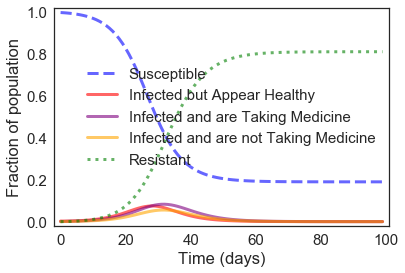

In [19]:
frame = system.results
plot_results(frame.S, frame.I_H, frame.I_M, frame.I_NM, frame.R)

In [17]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [21]:
for beta in beta_array:
    system = make_system(beta, gamma)
    run_simulation(system, update1)
    system.beta, calc_total_infected(system)

In [22]:
def sweep_beta(beta_array, gamma):
    """SweepSeriess a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_simulation(system, update1)
        sweep[system.beta] = calc_total_infected(system)
    return sweep

In [23]:
infected_sweep = sweep_beta(beta_array, gamma)

Saving figure to file chap06-fig01.pdf


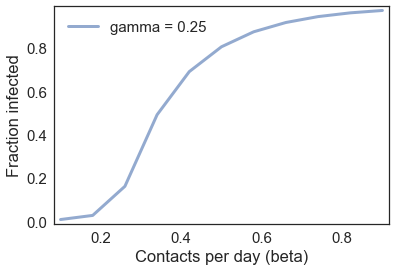

In [24]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('chap06-fig01.pdf')